In [1]:
import os
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import numpy as np
import configs
import seaborn as sns
import pandas as pd
import h5py

In [16]:
exp = 'pnet'
engram_dir = '/mnt/smb/locker/abbott-locker/hcnn/'
tensorboard_dir = f'{engram_dir}2_hyperp/{exp}/'
activations_dir = f'{engram_dir}3_activations/{exp}/'
pickles_dir = f'{engram_dir}pickles/'
plot_ci = True

# Helper functions

In [3]:
def get_hyperparams(tf_filepath, bg, snr):
    hyperparams = []
    ea = event_accumulator.EventAccumulator(tf_filepath)
    ea.Reload()
    eval_score = [0]
    epoch = 0
    while True:
        try:
            score_over_t = 0.
            for t in np.arange(1,5):
                score_over_t += ea.Scalars(f'NoisyPerf/Epoch#{epoch}')[t].value
                epoch += 1
            score_over_t /= 4
            eval_score.append(score_over_t)
        except Exception as e:
            break
    for i in range(1, 6):
        hps = {}
        ffm = ea.Scalars(f'Hyperparam/pcoder{i}_feedforward')[-1].value
        fbm = ea.Scalars(f'Hyperparam/pcoder{i}_feedback')[-1].value
        erm = ea.Scalars(f'Hyperparam/pcoder{i}_error')[-1].value
        if np.isnan(ffm) or np.isnan(fbm) or np.isnan(erm):
            return None, 0.
        hps['ffm'] = ffm
        hps['fbm'] = fbm
        hps['erm'] = erm
        hyperparams.append(hps)
    return hyperparams, eval_score[-1]

In [4]:
def eval_accuracy(results, timestep=4):
    """ t is the timestep to eval """
    labels = np.array(results['label'])
    timesteps = []
    accuracies = []
    rel_accuracies = []
    ff_corrects = []
    clean_corrects = []
    n_timesteps = 5
    
    for i in range(labels.size):
        label = labels[i]
        ff_acc = None
        for t in range(n_timesteps):
            output = results[f'{t}_output'][i]
            acc_t = (output == label).astype(float)
            if t == 0:
                ff_acc = acc_t
            rel_acc_t = acc_t - ff_acc
            if  t != timestep:
                continue
            timesteps.append(t)
            accuracies.append(acc_t)
            rel_accuracies.append(rel_acc_t)
            ff_corrects.append(ff_acc)
            clean_corrects.append(results['clean_correct'][i])

    timesteps = np.array(timesteps)
    accuracies = np.array(accuracies)
    rel_accuracies = np.array(rel_accuracies)
    ff_corrects = np.array(ff_corrects)
    clean_corrects = np.array(clean_corrects)
            
    return timesteps, accuracies, rel_accuracies, ff_corrects, clean_corrects

# Collect hyperparameter values

In [11]:
feedforward = []
feedback = []
memory = []
error_scaling = []
bg = []
snr = []
layers = []

for tfdir in os.listdir(tensorboard_dir):
    if 'hyper' not in tfdir: continue
    noise_info = tfdir.split('_')
    _snr = float(noise_info[-1][3:])
    _bg = noise_info[1]
    best_score = 0.
    best_hyperparams = None
    best_tf_file = None
    tf_dir = tensorboard_dir + tfdir + '/'
    all_scores = []
    for tf_file in os.listdir(tf_dir):
        tf_filepath = f'{tf_dir}{tf_file}'
        tf_file = tf_file.split('edu.')[-1]
        hyperparams, score = get_hyperparams(tf_filepath, bg, snr)
        if hyperparams is None:
            continue
        all_scores.append(score)
        if score > best_score:
            best_score = score
            best_hyperparams = hyperparams
            best_tf_file = tf_file
    print(f'{_bg}, SNR {_snr} uses {best_tf_file} with valid score {best_score} out of {all_scores}')
    
    for _layer, hps in enumerate(best_hyperparams):
        feedforward.append(hps['ffm'])
        feedback.append(hps['fbm'])
        memory.append(1 - (hps['ffm'] + hps['fbm']))
        error_scaling.append(hps['erm'])
        bg.append(_bg)
        snr.append(_snr)
        layers.append(_layer)

# Make pandas dataframe
df = pd.DataFrame({
    'Feedforward': feedforward,
    'Feedback': feedback,
    'Memory': memory,
    'Error Scaling': error_scaling,
    'Background Noise': bg,
    'SNR': snr, 
    'Layer': layers
    })


Babble8Spkr, SNR -6.0 uses 48958.1 with valid score 0.1282999999821186 out of [0.1019000019878149, 0, 0.09879999980330467, 0.11390000022947788, 0.1282999999821186, 0.12365000136196613, 0, 0.09190000221133232, 0.12189999967813492]
pinkNoise, SNR 3.0 uses 11669.2 with valid score 0.8708999902009964 out of [0.8616500049829483, 0.8392500132322311, 0.8708999902009964, 0.8613999933004379, 0.8687499910593033]
pinkNoise, SNR -6.0 uses 12917.3 with valid score 0.5734499990940094 out of [0.5734499990940094, 0.1110499994829297, 0.5582000017166138, 0.5616000145673752, 0.5619499981403351]
AudScene, SNR -3.0 uses 51441.0 with valid score 0.6244000047445297 out of [0.6244000047445297, 0.6137000024318695]
AudScene, SNR 0.0 uses 51442.1 with valid score 0.7575500160455704 out of [0.7575500160455704, 0.7545999884605408]
pinkNoise, SNR -9.0 uses 34545.1 with valid score 0.37640000134706497 out of [0.3534500002861023, 0.3568499907851219, 0.37640000134706497, 0.3590000048279762]
pinkNoise, SNR 0.0 uses 475

# As a function of SNR, collapsed across layers

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


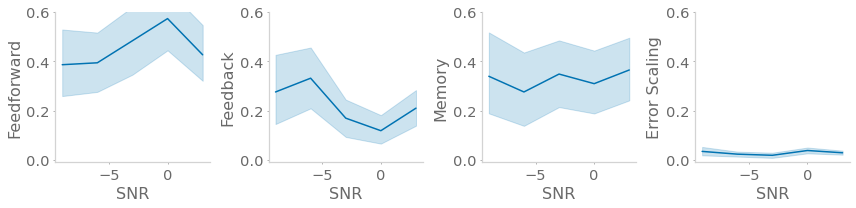

In [7]:
fig, axs = plt.subplots(1, 4, figsize = (12,3))
sns.lineplot(
    x='SNR', y='Feedforward', ax=axs[0], data=df)
sns.lineplot(
    x='SNR', y='Feedback', ax=axs[1], data=df, legend=None)
sns.lineplot(
    x='SNR', y='Memory', ax=axs[2], data=df, legend=None)
sns.lineplot(
    x='SNR', y='Error Scaling', ax=axs[3], data=df, legend=None)
for ax in axs:
    ax.set_ylim(-0.01, 0.6)
    #ax.axhline(0, color='blue', linestyle='--')
plt.tight_layout()
plt.show()

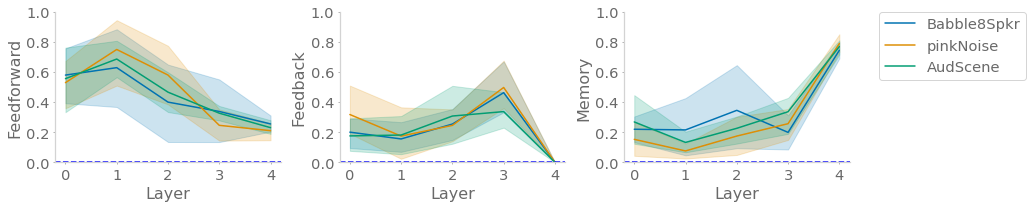

In [8]:
fig, axs = plt.subplots(1, 3, figsize = (12,3))
sns.lineplot(
    x='Layer',hue='Background Noise', y='Feedforward', ax=axs[0], data=df, legend=None)
sns.lineplot(
    x='Layer',hue='Background Noise', y='Feedback', ax=axs[1], data=df, legend=None)
sns.lineplot(
    x='Layer',hue='Background Noise', y='Memory', ax=axs[2], data=df)
for ax in axs:
    ax.set_ylim(0.0, 1.)
    ax.axhline(0, color='blue', linestyle='--')
plt.tight_layout()
axs[2].legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

# As a function of layers, collapsed across SNR/BG

In [9]:
from scipy.stats import sem

/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


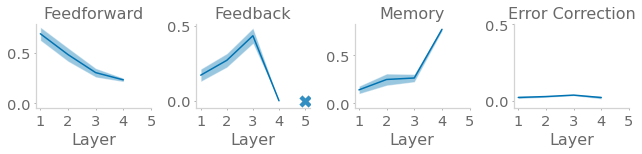

In [10]:
fig, axs = plt.subplots(1, 4, figsize = (10*0.9,3*0.75)) #12, 3
hyperparams = ['Feedforward', 'Feedback', 'Memory', 'Error Scaling']
layers = np.arange(1, 6)

for h_idx, hyperparam in enumerate(hyperparams):
    layer_x_axis = []
    layer_means = []
    layer_sems = []
    for layer in layers:
        if hyperparam == 'Feedback' and layer == 5:
            continue
        vals = df[df['Layer']==layer][hyperparam]
        layer_x_axis.append(layer)
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    axs[h_idx].plot(layer_x_axis, layer_means)
    axs[h_idx].fill_between(
        layer_x_axis, layer_means-layer_sems, layer_means+layer_sems,
        alpha=0.4
        )
    axs[h_idx].set_title(hyperparam)
    if hyperparam == 'Error Scaling':
        axs[h_idx].set_title('Error Correction')
axs[1].scatter(
    5, 0., marker='X', color='C0', alpha=0.8, s=150, linewidths=0)

for ax in axs:
    ax.set_ylim(bottom=-0.05)
    ax.set_xticks([1,2,3,4,5])
    ax.set_yticks([0.0, 0.5])
    ax.set_xlabel('Layer')
plt.tight_layout()
plt.savefig('hyperparameters.png', dpi=300)
plt.show()
print('\n\n')

# As a function of layers, collapsed across SNR/BG, and activity normalized

In [9]:
from scipy.stats import sem

In [19]:
import pickle

In [32]:
with open(f'{pickles_dir}{exp}_activity_norm.p', 'rb') as f:
    norms_df = pd.DataFrame(pickle.load(f))

In [41]:
norms = {}
for bg in np.unique(norms_df['bg']):
    norms[bg] = {}
    for snr in np.unique(norms_df['snr']):
        norms[bg][snr] = {}
        for layer in [1,2,3,4,5]:
            norms[bg][snr][layer] = {}
            for key in ['Feedforward', 'Feedback', 'Memory', 'Error Scaling']:
                norms[bg][snr][layer][key] = None

In [42]:
for bg in np.unique(norms_df['bg']):
    for snr in np.unique(norms_df['snr']):
        _norms_df = norms_df[norms_df['bg']==bg]
        _norms_df = _norms_df[_norms_df['snr']==snr]
        _norms_df = _norms_df[_norms_df['t']==1]
        for layer in [1,2,3,4,5]:
            layer_df = _norms_df[_norms_df['layer']==layer]
            norms[bg][snr][layer]['Feedforward'] = np.mean(layer_df['ff'])
            norms[bg][snr][layer]['Feedback'] = np.mean(layer_df['fb'])
            norms[bg][snr][layer]['Memory'] = np.mean(layer_df['mem'])
            norms[bg][snr][layer]['Error Scaling'] = np.mean(layer_df['err'])

In [45]:
df

,Feedforward,Feedback,Memory,Error Scaling,Background Noise,SNR,Layer
0,0.821746,0.034417,0.143837,0.005097,Babble8Spkr,-6.0,0
1,0.875354,0.082034,0.042612,0.000500,Babble8Spkr,-6.0,1
2,0.296360,0.423792,0.279848,-0.011901,Babble8Spkr,-6.0,2
3,0.682106,0.276011,0.041883,0.025552,Babble8Spkr,-6.0,3
4,0.347077,0.000000,0.652923,0.010450,Babble8Spkr,-6.0,4
...,...,...,...,...,...,...,...
70,0.642098,0.320136,0.037767,0.028145,pinkNoise,-3.0,0
71,0.943307,0.029816,0.026876,-0.000228,pinkNoise,-3.0,1
72,0.824046,0.160362,0.015592,0.024147,pinkNoise,-3.0,2
73,0.411620,0.381652,0.206728,0.020421,pinkNoise,-3.0,3


In [56]:
scaled_df = df.copy()
for i, row in df.iterrows():
    bg = df.at[i, 'Background Noise']
    snr = df.at[i, 'SNR']
    layer = df.at[i, 'Layer']
    layer_norms = norms[bg][snr][layer+1]
    scaled_terms = np.array([
        df.at[i,'Feedforward']*layer_norms['Feedforward'],
        df.at[i,'Feedback']*layer_norms['Feedback'],
        df.at[i,'Memory']*layer_norms['Memory']])
    scaled_terms_sum = scaled_terms.sum()
    scaled_terms /= scaled_terms_sum
    scaled_err = df.at[i,'Error Scaling']*layer_norms['Error Scaling'] / scaled_terms_sum
    scaled_df.at[i,'Feedforward'] = scaled_terms[0]
    scaled_df.at[i,'Feedback'] = scaled_terms[1]
    scaled_df.at[i,'Memory'] = scaled_terms[2]
    scaled_df.at[i,'Error Scaling'] = scaled_err

/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/home/cf2794/.conda/envs/hcnn/lib/python3.7/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


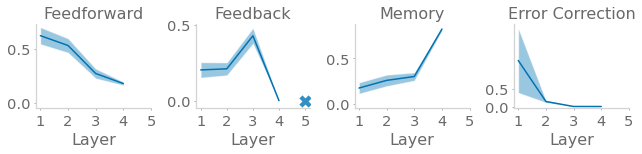

In [57]:
fig, axs = plt.subplots(1, 4, figsize = (10*0.9,3*0.75)) #12, 3
hyperparams = ['Feedforward', 'Feedback', 'Memory', 'Error Scaling']
layers = np.arange(1, 6)

for h_idx, hyperparam in enumerate(hyperparams):
    layer_x_axis = []
    layer_means = []
    layer_sems = []
    for layer in layers:
        if hyperparam == 'Feedback' and layer == 5:
            continue
        vals = scaled_df[scaled_df['Layer']==layer][hyperparam]
        layer_x_axis.append(layer)
        layer_means.append(np.mean(vals))
        layer_sems.append(sem(vals))
    layer_means = np.array(layer_means)
    layer_sems = np.array(layer_sems)
    axs[h_idx].plot(layer_x_axis, layer_means)
    axs[h_idx].fill_between(
        layer_x_axis, layer_means-layer_sems, layer_means+layer_sems,
        alpha=0.4
        )
    axs[h_idx].set_title(hyperparam)
    if hyperparam == 'Error Scaling':
        axs[h_idx].set_title('Error Correction')
axs[1].scatter(
    5, 0., marker='X', color='C0', alpha=0.8, s=150, linewidths=0)

for ax in axs:
    ax.set_ylim(bottom=-0.05)
    ax.set_xticks([1,2,3,4,5])
    ax.set_yticks([0.0, 0.5])
    ax.set_xlabel('Layer')
plt.tight_layout()
plt.savefig('hyperparameters.png', dpi=300)
plt.show()
print('\n\n')